# Analyze and plot Divvy trips

In [13]:
%matplotlib inline
import sodapy
import matplotlib.pyplot as pp
import numpy as np
import smopy

data_url = 'data.cityofchicago.org'
divvy_data = 'fg6s-gzvg'

## Example: Print most recent 10 trips for a bike

Stetson Ave & South Water St  >>  McClurg Ct & Illinois St
McClurg Ct & Illinois St  >>  Michigan Ave & Oak St
Michigan Ave & Oak St  >>  Theater on the Lake
Canal St & Madison St  >>  Michigan Ave & Lake St
Millennium Park  >>  Adler Planetarium
Adler Planetarium  >>  Fairbanks Ct & Grand Ave
Clinton St & Washington Blvd  >>  Wells St & Erie St
Wells St & Erie St  >>  Clinton St & Washington Blvd
Canal St & Adams St  >>  State St & Erie St
State St & Erie St  >>  Dearborn St & Adams St


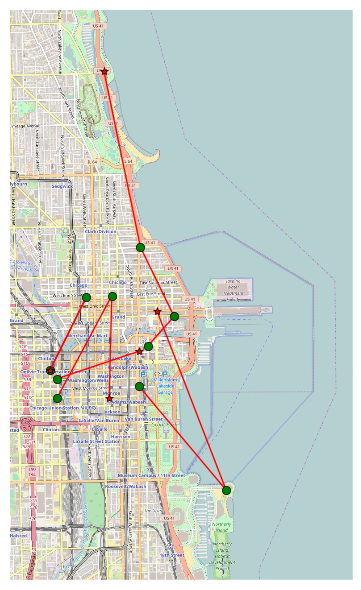

In [112]:
# Get most recent 10 trips
data = sodapy.Socrata(data_url, None)
trip_chain = data.get(divvy_data, bike_id=2538,
                      limit=10, order='stop_time ASC')
data.close()

map_chi = smopy.Map((41.86, -87.645, 41.93, -87.605), z=14)
ax = map_chi.show_mpl(figsize=(8, 6))

for t in trip_chain:
    print t['from_station_name'], ' >> ', t['to_station_name']

    from_lat = float(t['from_latitude'])
    to_lat = float(t['to_latitude'])
    from_lon = float(t['from_longitude'])
    to_lon = float(t['to_longitude'])
    
    x1, y1 = map_chi.to_pixels(from_lat, from_lon)
    x2, y2 = map_chi.to_pixels(to_lat, to_lon)

    ax.plot([x1, x2], [y1, y2], 'r')
    ax.plot(x1, y1, 'go')
    ax.plot(x2, y2, 'r*')

pp.show()

## Analyze trip chains
A trip chain is a series of contiguous trips (from station to station) where each trip starts at the same station as where the previous trip ended.

Trip chains are presumably disrupted for several reasons including
- Maintenance
- Removal for special events
- Load balancing

### Tripchain length for a random bike

Average tripchain length: 6.14


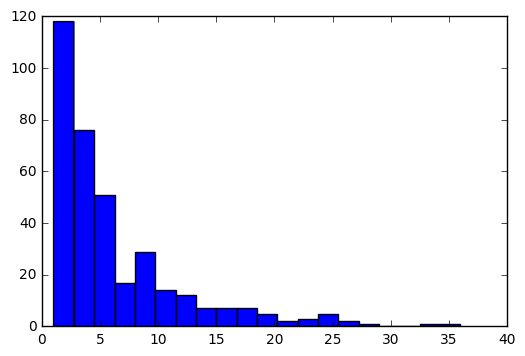

In [17]:
import tripchains
bike_id = 1000  # random bike

# Get all trips for bike, oldest first
data = sodapy.Socrata(data_url, None)
all_trips = data.get(divvy_data,
                     bike_id=bike_id,
                     limit=10000,
                     order='stop_time ASC')
data.close()

tc_starts = tripchains.tripchain_starts(all_trips)
tc_len = tripchains.tripchain_lengths(tc_starts, len(all_trips))

print 'Average tripchain length: {0:4.2f}'.format(np.mean(tc_len))

pp.hist(tc_len, bins=20)
pp.show()

### Analyze tripchains from many bikes (ensemble average)

Average tripchain length: 6.78
Weibull shape factor:  0.95


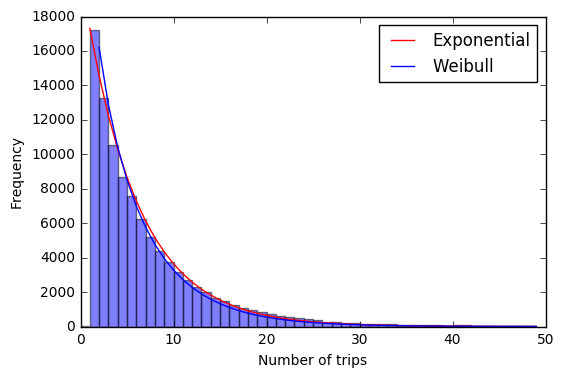

In [116]:
import scipy.stats
n_tc = 100000      # Number of tripchains to include in average
tc_len = [0]*n_tc  # Tripchain length

with open('tripchains.txt') as f:
    f.readline()  # Discard header row
    for i in range(n_tc):
        line = f.readline().split(',')
        tc_len[i] = int(line[1])
        
# Average statistics
print 'Average tripchain length: {:4.2f}'.format(np.mean(tc_len))

# Fit exponential distribution
# exponential statistics would be expected if bike removal is a Poisson process
exp_loc, exp_scale = scipy.stats.expon.fit(tc_len)
exp_dist = scipy.stats.expon(loc=exp_loc, scale=exp_scale)

# Fit Weibull distribution
wei_c, wei_loc, wei_scale = scipy.stats.dweibull.fit(tc_len, floc=1.0)
wei_dist = scipy.stats.dweibull(c=wei_c, loc=wei_loc, scale=wei_scale)
print 'Weibull shape factor: ', wei_c

# Truncate histogram to 50 trips
pp.hist(tc_len, bins=range(50), alpha=0.5)
pp.plot(bins[1:], n_tc*exp_dist.pdf(bins[1:]), 'r', label='Exponential')
pp.plot(bins[1:], 2*n_tc*wei_dist.pdf(bins[1:]), 'b', label='Weibull')

pp.xlabel('Number of trips')
pp.ylabel('Frequency')
pp.legend()
pp.show()